### c) Load the segmentation image, and the corresponding CT image with PyDicom. Rearrange the image and segmentation ‘pixel array’ given by PyDicom based on the headers. Some relevant headers include:
* ‘Acquisition Number’.
* ‘Slice Index’.
* ‘Per-frame Functional Groups Sequence’ --> ‘Image Position Patient’.
* ‘Segment Identification Sequence’ --> ‘Referenced Segment Number’.

## Carga y visualización de las imágenes DICOM

#### Cargar Archivos DICOM
Cargo los archivos DICOM desde el directorio especificado. Trabajo inicialmente con un subconjunto de los archivos para testear.

**¿Con que CT trabajo? No me ha quedado claro qué subconjunto de archivos usar!**



In [90]:
import pydicom
import os
import matplotlib.pyplot as plt

# Ruta al directorio donde están almacenados los archivos DICOM
directory_path = '/Users/pedromarti/Desktop/Master/AIM/Practica/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/2.000000-PRE LIVER-48636'

# Función para cargar todos los archivos DICOM en un directorio
def load_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.dcm'):
            filepath = os.path.join(directory, filename)
            dicom_files.append(pydicom.dcmread(filepath))
    return dicom_files

# Cargando los archivos DICOM
dicom_images = load_dicom_files(directory_path)
print(f"Total de imágenes DICOM cargadas: {len(dicom_images)}")


Total de imágenes DICOM cargadas: 20


#### Visualización de las imágenes DICOM

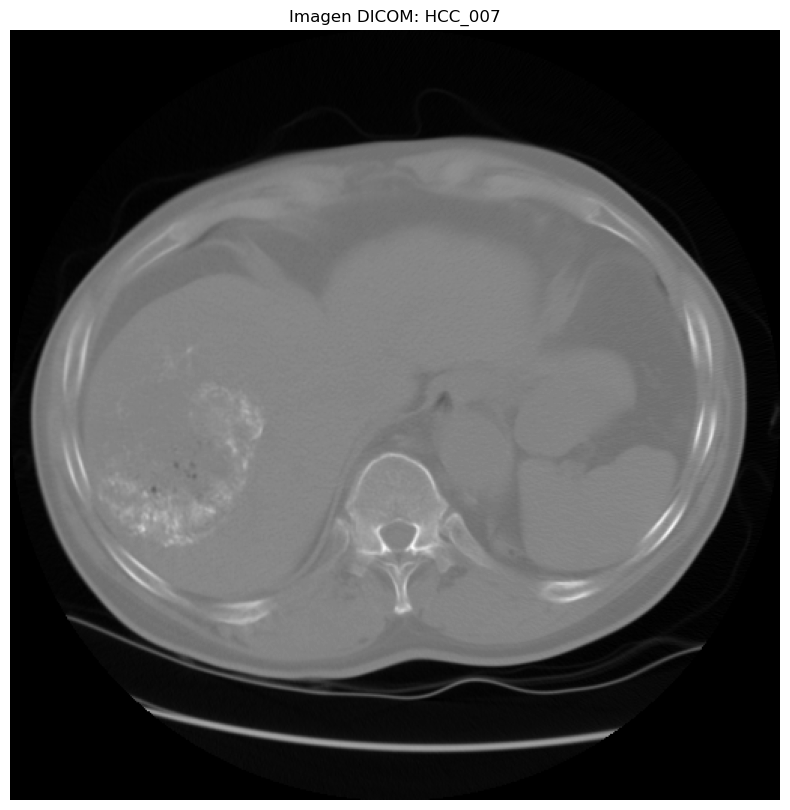

In [91]:
# Función para visualizar una imagen DICOM
def display_dicom_image(dicom_data):
    plt.figure(figsize=(10, 10))
    plt.imshow(dicom_data.pixel_array, cmap='gray')
    plt.title(f"Imagen DICOM: {dicom_data.PatientID}")
    plt.axis('off')
    plt.show()

# Visualizar la primera imagen DICOM cargada
if dicom_images:
    display_dicom_image(dicom_images[0])


#### Estudio de encabezados

In [99]:
# Función para imprimir encabezados relevantes de una imagen DICOM
def print_relevant_headers(dicom_data):
    print("Acquisition Number:", dicom_data.get('AcquisitionNumber', 'No disponible'))
    print("Image Position (Patient):", dicom_data.get('ImagePositionPatient', 'No disponible'))
    if 'PerFrameFunctionalGroupsSequence' in dicom_data:
        # Extrayendo solo el primer frame como ejemplo
        frame = dicom_data.PerFrameFunctionalGroupsSequence[0]
        print("Image Position (Patient) from Frame:", frame.ImagePositionPatient)
    if 'SegmentIdentificationSequence' in dicom_data:
        # Extrayendo el número de segmento referenciado
        segment = dicom_data.SegmentIdentificationSequence[0]
        print("Referenced Segment Number:", segment.ReferencedSegmentNumber)

# Imprimir encabezados de la primera imagen DICOM cargada
if dicom_images:
    print_relevant_headers(dicom_images[0])


Acquisition Number: 1
Image Position (Patient): [-203.500000, -180.000000, -144.729996]


#### Organización de las imágenes DICOM

Aqui uso el encabezado Image Position (Patient) para ordenar las imágenes.

In [94]:
# Ordenar las imágenes por la coordenada z de Image Position (Patient)
dicom_images_sorted = sorted(dicom_images, key=lambda x: float(x.ImagePositionPatient[2]))

# Verificar el orden de las imágenes
print("Orden de las imágenes por posición z:")
for img in dicom_images_sorted:
    print(img.ImagePositionPatient[2])


Orden de las imágenes por posición z:
-254.729996
-244.729996
-234.729996
-224.729996
-214.729996
-204.729996
-194.729996
-184.729996
-174.729996
-164.729996
-154.729996
-144.729996
-134.729996
-124.730003
-114.730003
-104.730003
-94.730003
-84.730003
-74.730003
-64.730003


Visualización de las imágenes ordenadas

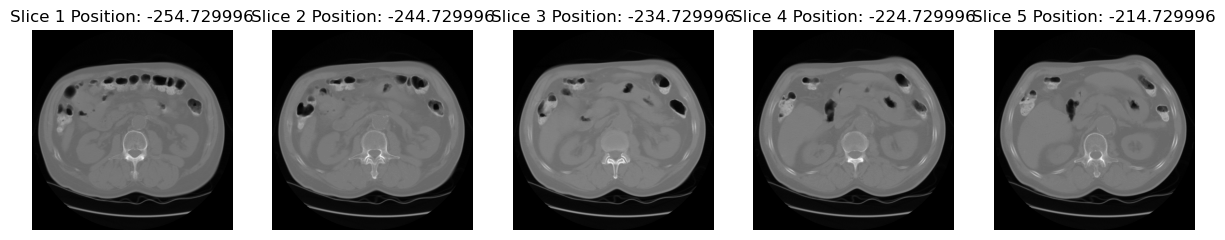

In [95]:
# Función para visualizar múltiples imágenes DICOM
def display_multiple_dicom_images(images, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 10))
    for i in range(num_images):
        axs[i].imshow(images[i].pixel_array, cmap='gray')
        axs[i].set_title(f"Slice {i+1} Position: {images[i].ImagePositionPatient[2]}")
        axs[i].axis('off')
    plt.show()

# Visualizar las primeras 5 imágenes para confirmar el orden
display_multiple_dicom_images(dicom_images_sorted[:5])


## MIP

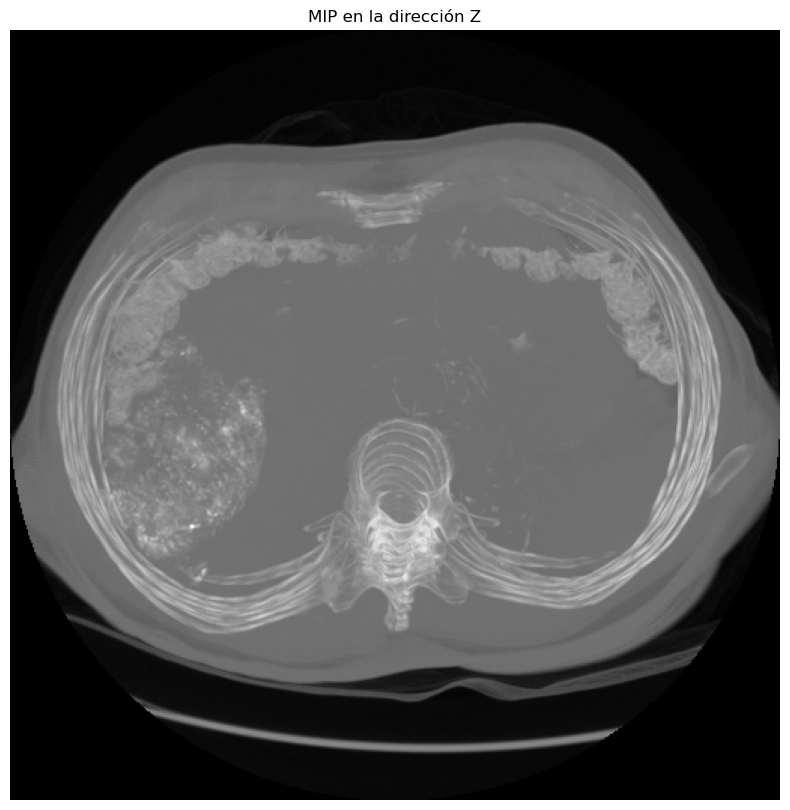

In [96]:
import numpy as np

# Función para crear una proyección de intensidad máxima (MIP)
def create_mip(images, axis=0):
    # Convertir imágenes DICOM en un array de numpy
    image_stack = np.stack([img.pixel_array for img in images])
    # Calcular el MIP a lo largo del eje especificado
    mip_image = np.max(image_stack, axis=axis)
    return mip_image

# Crear MIP para la dirección z
mip_z = create_mip(dicom_images_sorted)

# Visualizar la MIP
plt.figure(figsize=(10, 10))
plt.imshow(mip_z, cmap='gray')
plt.title("MIP en la dirección Z")
plt.axis('off')
plt.show()


-------------------------

In [100]:

import pydicom
import os
import numpy as np

# Rutas de las imágenes
segmented_image_path = '/Users/pedromarti/Desktop/Master/AIM/Practica/HCC_007/12-27-1997-NA-AP LIVER PRT WWO-67834/300.000000-Segmentation-39839/1-1.dcm'
#ct_image_path = '/Users/pedromarti/Desktop/Master/AIM/Practica/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/4.000000-Recon 2 3 PHASE LIVER ABD-87008/1-001.dcm'
ct_images_dir = '/Users/pedromarti/Desktop/Master/AIM/Practica/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/2.000000-PRE LIVER-48636'

# Cargar las imágenes
segmentation_image = pydicom.dcmread(segmented_image_path) # Cargar imagen de segmentación

# Cargar imágenes de CT
ct_files = [f for f in os.listdir(ct_images_dir) if f.endswith('.dcm')]
ct_images = [pydicom.dcmread(os.path.join(ct_images_dir, f)) for f in ct_files]

# Verificar la uniformidad de 'Acquisition Number'
acquisition_numbers = set(img.AcquisitionNumber for img in ct_images)
if len(acquisition_numbers) > 1:
    raise ValueError("Multiple acquisition numbers found. Ensure all CT images are from a single acquisition.")

# Organización de imágenes CT según 'Image Position Patient'
ct_images.sort(key=lambda x: float(x.ImagePositionPatient[2]))

# Mostrar detalles relevantes
print("Details of CT images sorted by Image Position Patient:")
for img in ct_images:
    print(f"Acquisition Number: {img.AcquisitionNumber}, Image Position Patient: {img.ImagePositionPatient}")

# Preparación de arrays de píxeles
segmentation_array = segmentation_image.pixel_array
ct_arrays = np.stack([img.pixel_array for img in ct_images])

print("Dimensiones del arreglo de segmentación:", segmentation_array.shape)
print("Dimensiones del arreglo de imágenes CT:", ct_arrays.shape)

Details of CT images sorted by Image Position Patient:
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -254.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -244.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -234.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -224.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -214.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -204.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -194.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -184.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -174.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -164.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -

## ----------------------------------------------------------------------------------

In [106]:


# Rutas de las imágenes
segmented_image_path = '/Users/pedromarti/Desktop/Master/AIM/Practica/HCC_007/12-27-1997-NA-AP LIVER PRT WWO-67834/300.000000-Segmentation-39839/1-1.dcm'
#ct_image_path = '/Users/pedromarti/Desktop/Master/AIM/Practica/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/4.000000-Recon 2 3 PHASE LIVER ABD-87008/1-001.dcm'
ct_images_dir = '/Users/pedromarti/Desktop/Master/AIM/Practica/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/2.000000-PRE LIVER-48636'

# Cargar las imágenes
segmentation_image = pydicom.dcmread(segmented_image_path) # Cargar imagen de segmentación

# Cargar imágenes de CT
ct_files = [f for f in os.listdir(ct_images_dir) if f.endswith('.dcm')]
ct_images = [pydicom.dcmread(os.path.join(ct_images_dir, f)) for f in ct_files]

# Verificar la uniformidad de 'Acquisition Number'
acquisition_numbers = set(img.AcquisitionNumber for img in ct_images)
if len(acquisition_numbers) > 1:
    raise ValueError("Multiple acquisition numbers found. Ensure all CT images are from a single acquisition.")

# Organización de imágenes CT según 'Image Position Patient'
ct_images.sort(key=lambda x: float(x.ImagePositionPatient[2]))

# Mostrar detalles relevantes
print("Details of CT images sorted by Image Position Patient:")
for img in ct_images:
    print(f"Acquisition Number: {img.AcquisitionNumber}, Image Position Patient: {img.ImagePositionPatient}")

# Preparación de arrays de píxeles
segmentation_array = segmentation_image.pixel_array
ct_arrays = np.stack([img.pixel_array for img in ct_images])

print("Dimensiones del arreglo de segmentación:", segmentation_array.shape)
print("Dimensiones del arreglo de imágenes CT:", ct_arrays.shape)

Details of CT images sorted by Image Position Patient:
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -254.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -244.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -234.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -224.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -214.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -204.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -194.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -184.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -174.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -164.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -

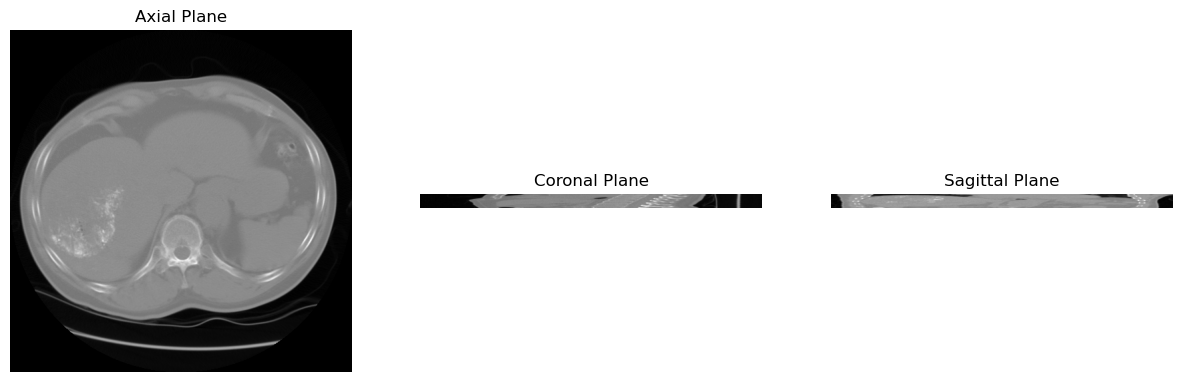

In [103]:
def visualize_planes(ct_volume):
    # Extraer los planos coronal y sagital
    coronal_plane = ct_volume[:, :, ct_volume.shape[2]//2]  # slice en el medio del eje X
    sagittal_plane = ct_volume[:, ct_volume.shape[1]//2, :]  # slice en el medio del eje Y
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(ct_volume[ct_volume.shape[0]//2], cmap='gray')  # Plano axial
    axes[0].set_title('Axial Plane')
    axes[1].imshow(coronal_plane, cmap='gray', origin='lower')
    axes[1].set_title('Coronal Plane')
    axes[2].imshow(sagittal_plane, cmap='gray', origin='lower')
    axes[2].set_title('Sagittal Plane')
    
    for ax in axes:
        ax.axis('off')
    plt.show()

# Visualizar los planos
visualize_planes(ct_arrays)

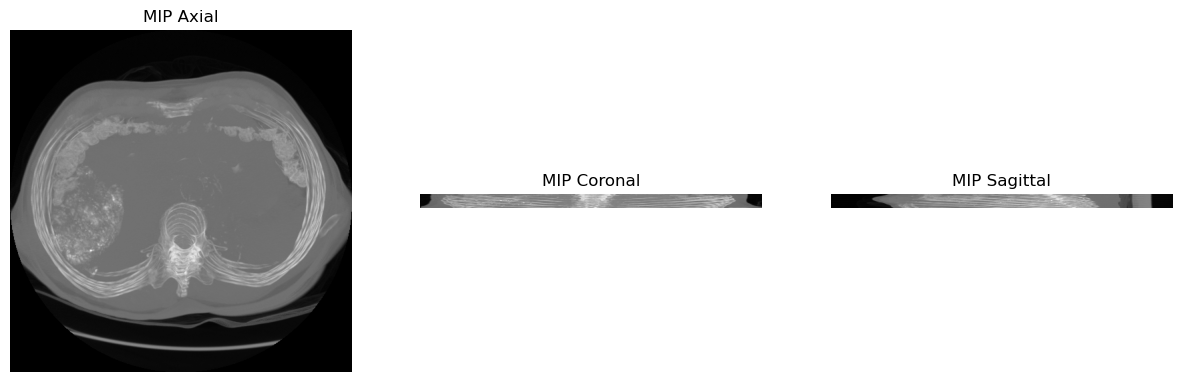

In [104]:
def create_mip(ct_volume):
    mip_axial = np.max(ct_volume, axis=0)
    mip_coronal = np.max(ct_volume, axis=1)
    mip_sagittal = np.max(ct_volume, axis=2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(mip_axial, cmap='gray')
    axes[0].set_title('MIP Axial')
    axes[1].imshow(mip_coronal, cmap='gray')
    axes[1].set_title('MIP Coronal')
    axes[2].imshow(mip_sagittal, cmap='gray')
    axes[2].set_title('MIP Sagittal')
    
    for ax in axes:
        ax.axis('off')
    plt.show()

# Generar y visualizar MIP
create_mip(ct_arrays)


## Visualización

#### Pregunta: ¿Hem d'aplicar una transformació d'intensitat per a que l'image es visualitzi millor (Windowing)? T2 pg 28-33

Visualización de correspondencias

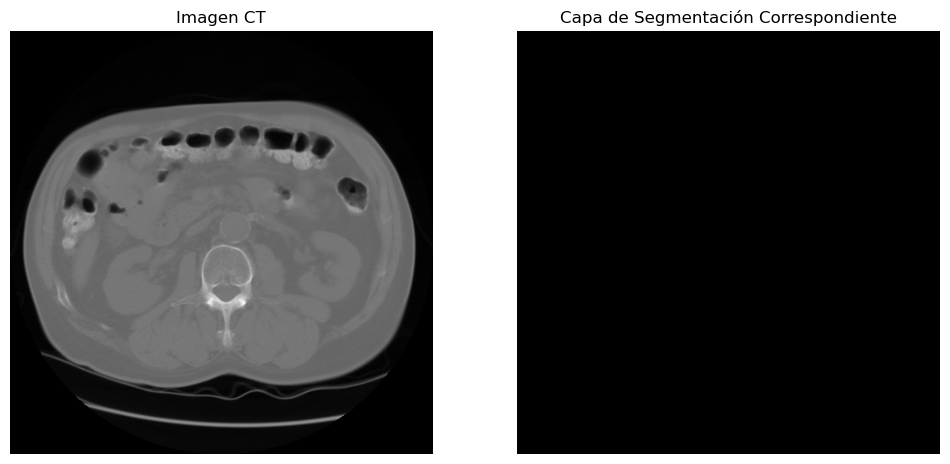

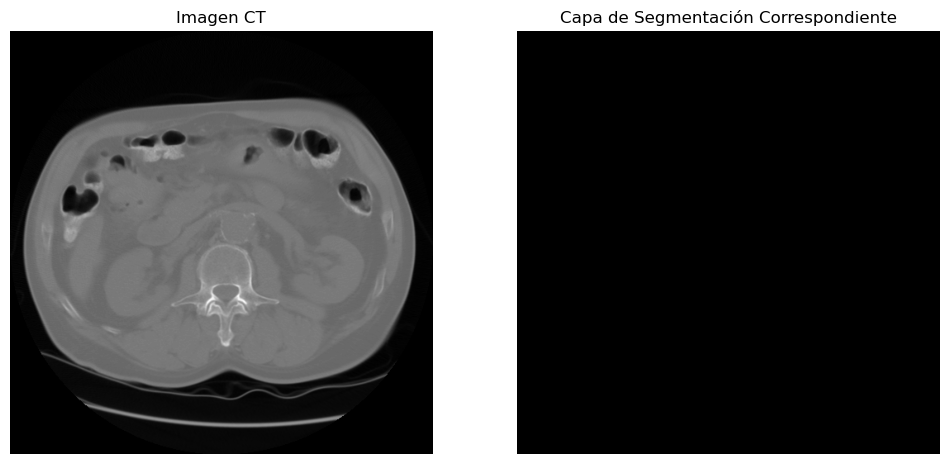

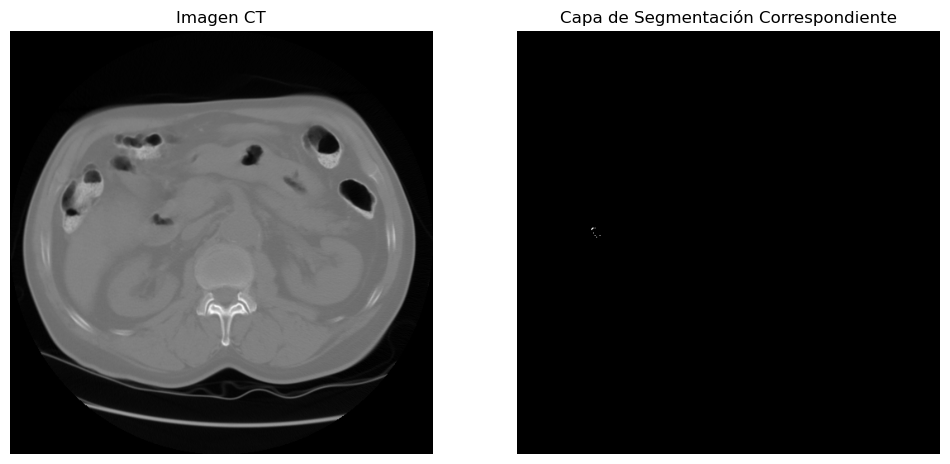

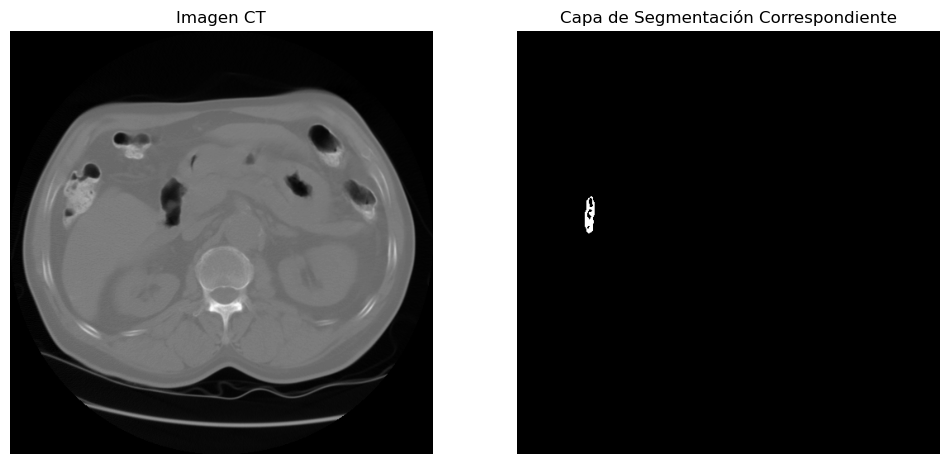

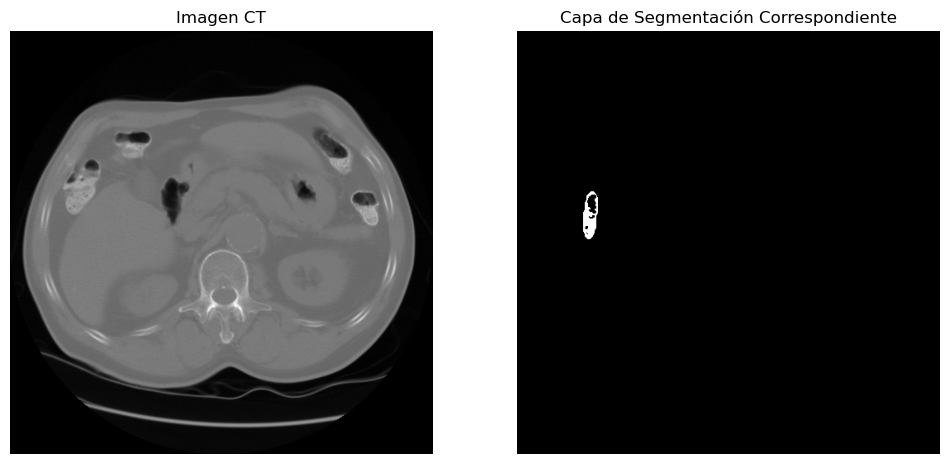

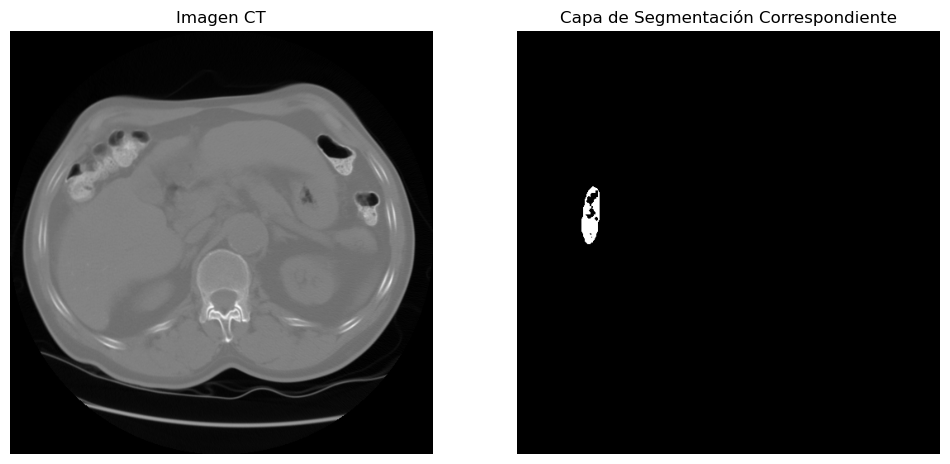

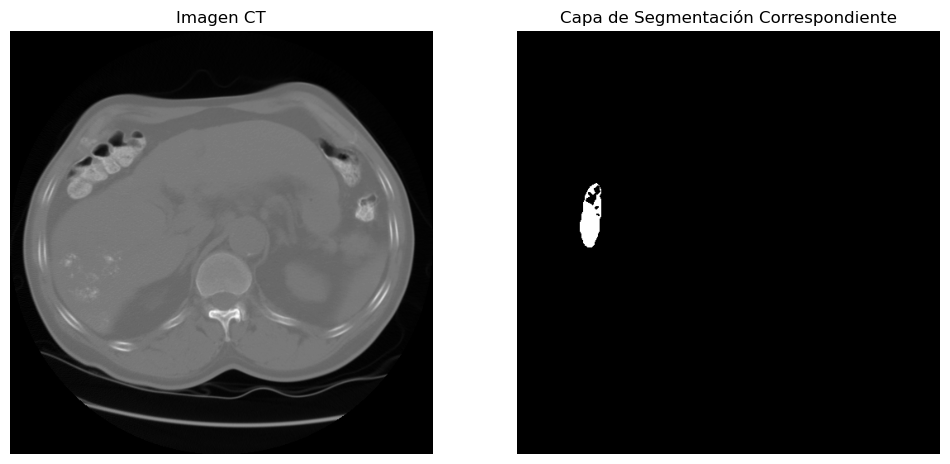

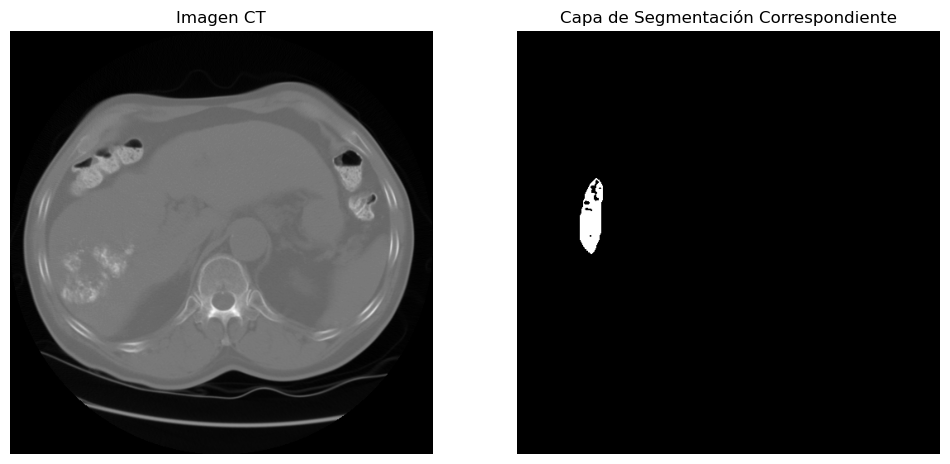

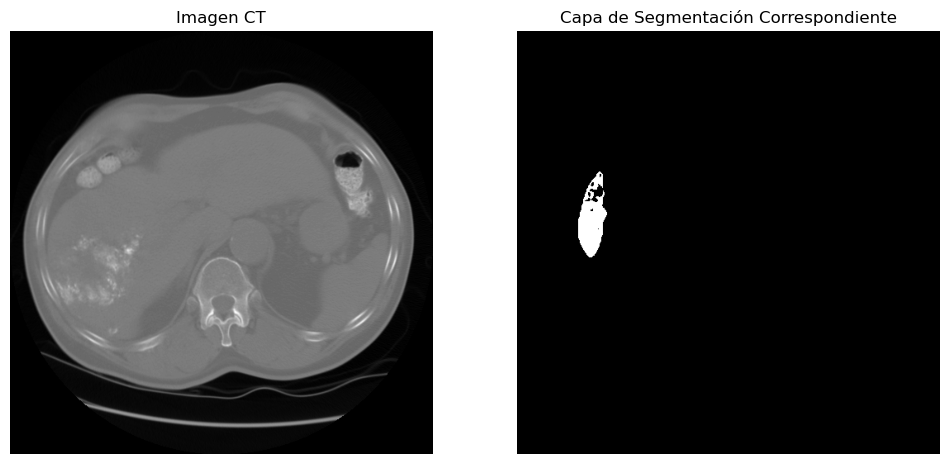

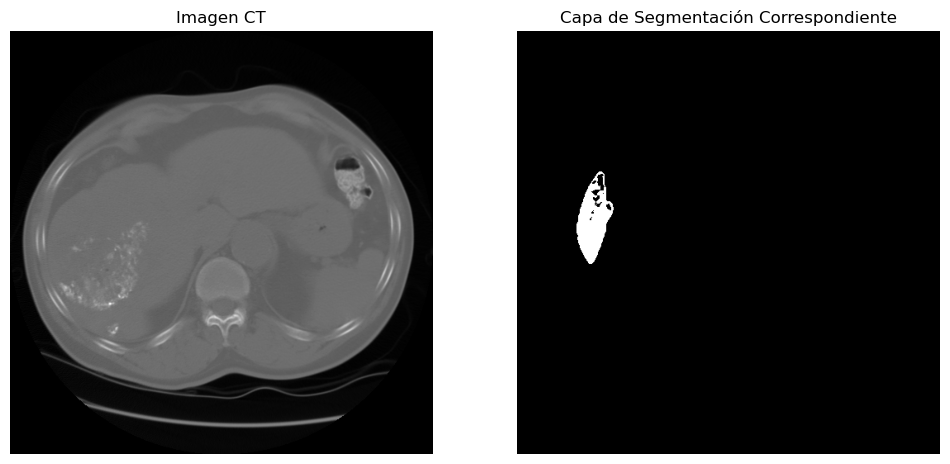

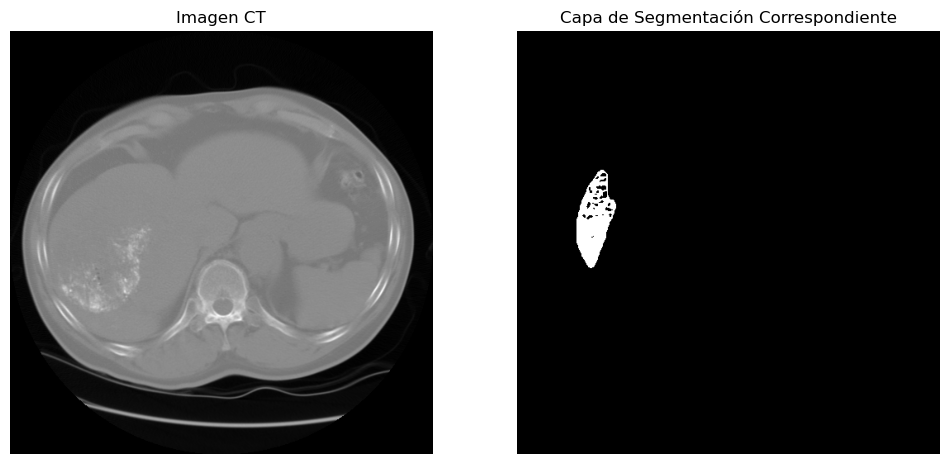

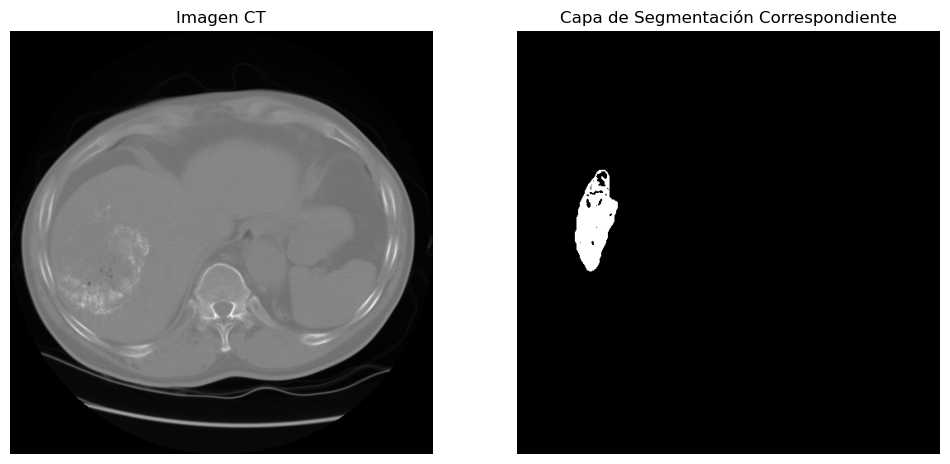

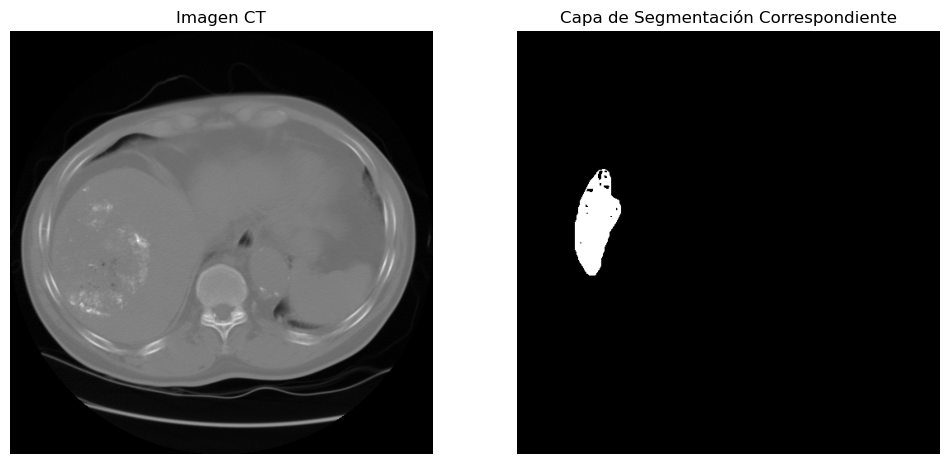

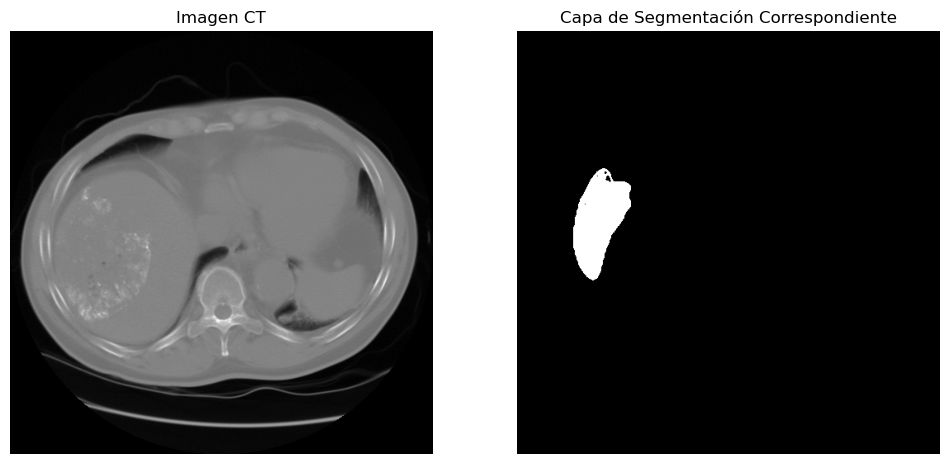

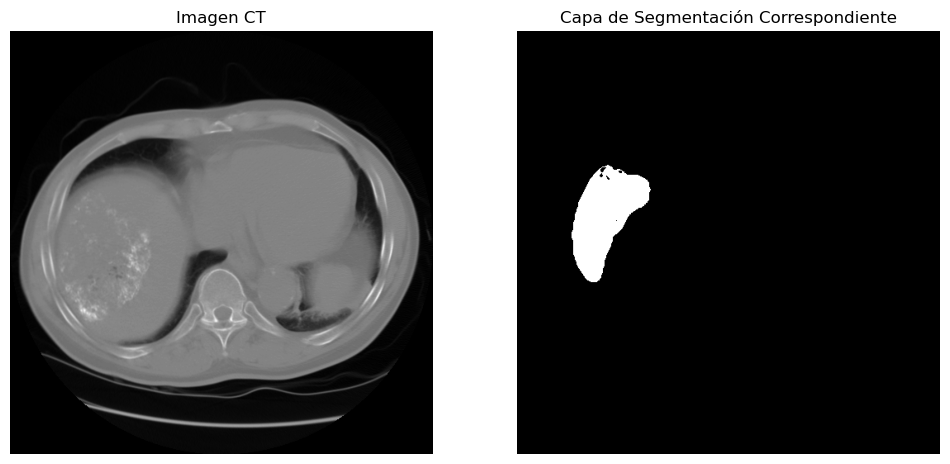

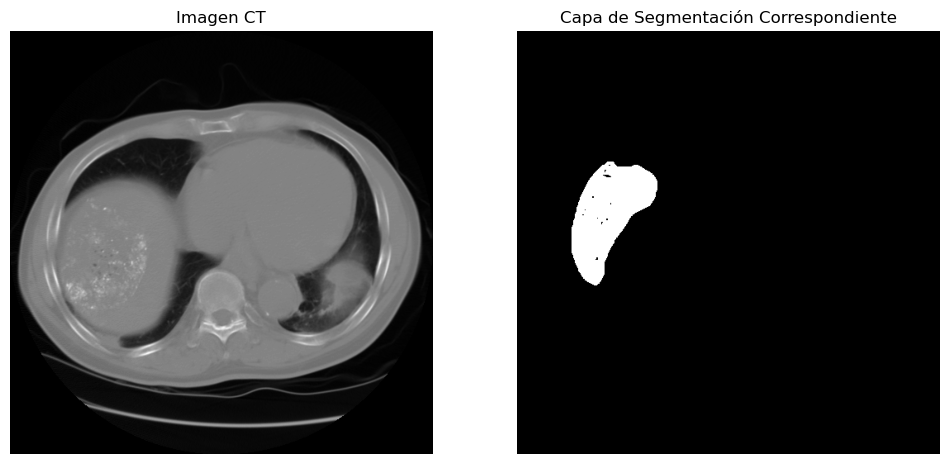

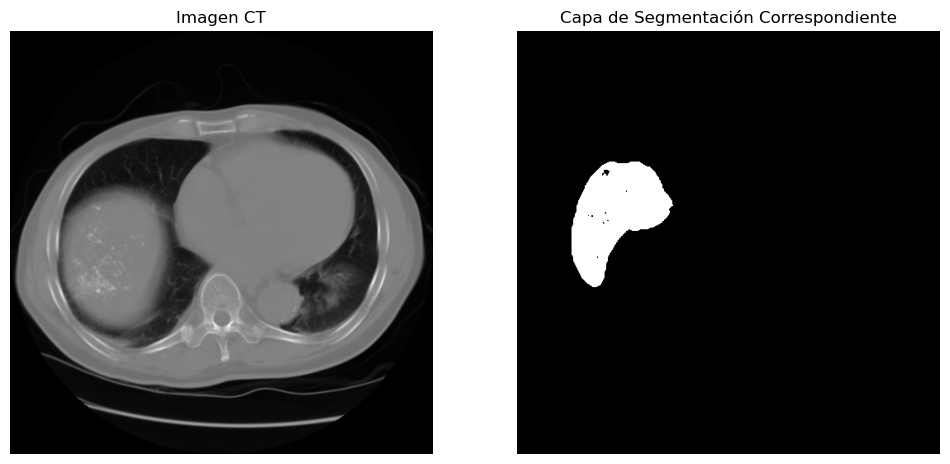

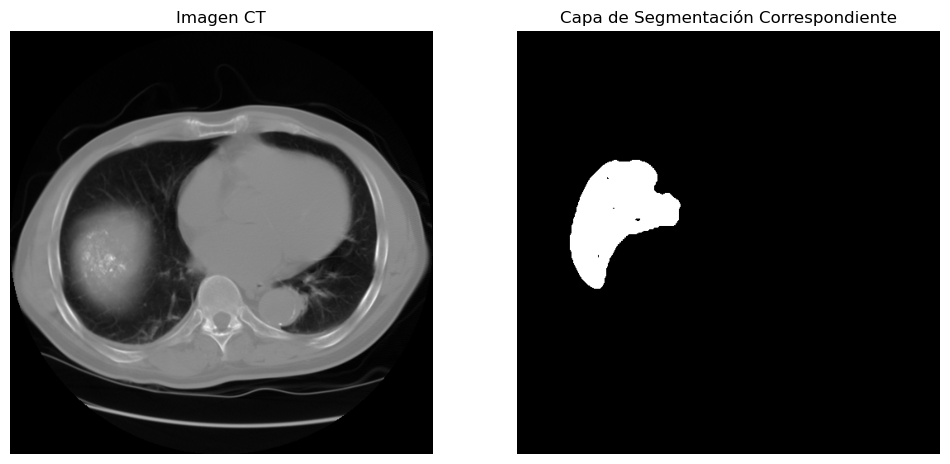

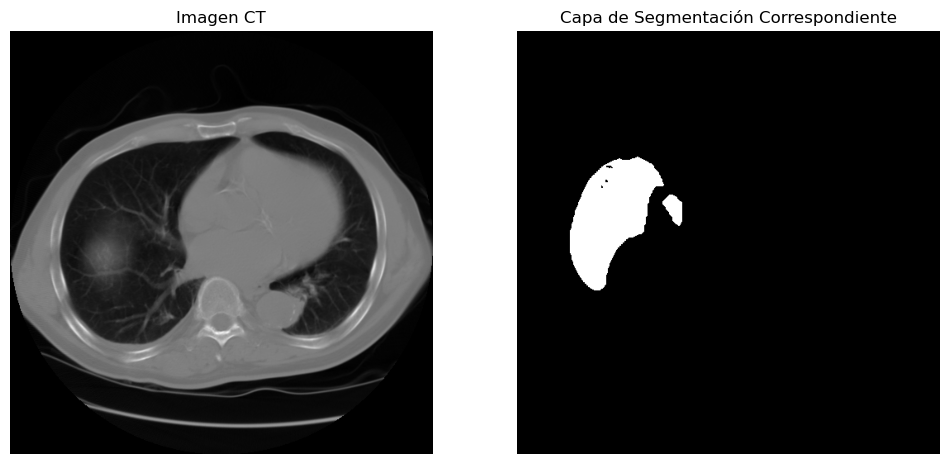

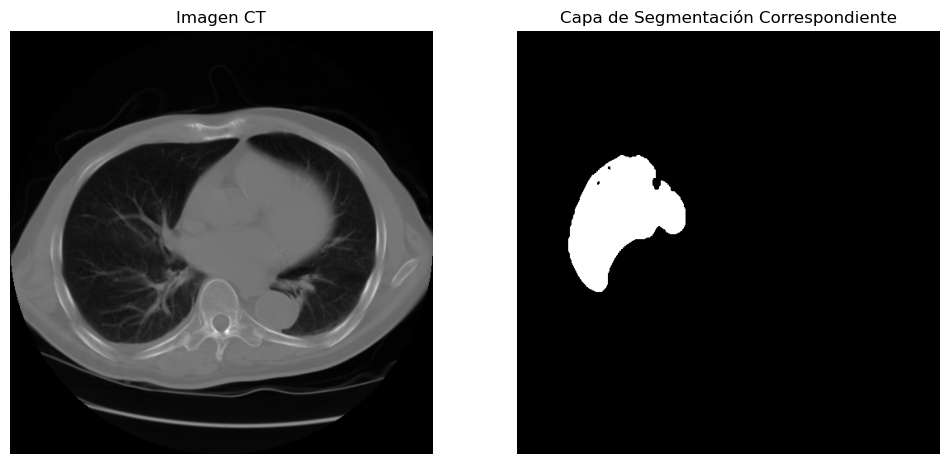

In [30]:
# Función para visualizar imágenes CT y de segmentación
def plot_images(ct_image, segmentation_layer):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(ct_image, cmap='gray')
    ax[0].set_title('Imagen CT')
    ax[0].axis('off')

    ax[1].imshow(segmentation_layer, cmap='gray')
    ax[1].set_title('Capa de Segmentación Correspondiente')
    ax[1].axis('off')

    plt.show()

# Suponiendo que cada capa de segmentación corresponde directamente a cada imagen CT (esto es solo un ejemplo)
for i in range(len(ct_arrays)):
    plot_images(ct_arrays[i], segmentation_array[i])


In [ ]:
# Crear MIPs en los planos requeridos
mip_coronal = np.max(image_data, axis=0)
mip_sagital = np.max(image_data, axis=1)

# Generar imágenes para el GIF
images = []
angles = range(0, 360, 10)
for angle in angles:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(mip_coronal, cmap='gray', origin='lower')
    ax[1].imshow(mip_sagital, cmap='gray', origin='lower')
    
    # Rotar la imagen
    ax[0].view_init(30, angle)
    ax[1].view_init(30, angle)
    
    # Convertir el plot en imagen para añadirlo al array de imágenes
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
    plt.close(fig)

# Guardar imágenes como GIF
imageio.mimsave('rotating_mip.gif', images, fps=10)


## Corregistration

In [ ]:
import numpy as np

# Definir la matriz de transformación para la traslación
def translate_image(image, offset):
    translated_image = np.roll(image, shift=offset, axis=(0,1))  # Traslada en ambos ejes
    return translated_image

# Aplicar la traslación
offset = [10, 10]  # Desplazar 10 píxeles en x e y
translated_image = translate_image(image_data, offset)

# Mostrar la imagen trasladada
plt.imshow(translated_image, cmap='gray')
plt.title("Translated Image")
plt.axis('off')
plt.show()